/home/plorenc/Desktop/AiR_ISS/OpenCL/lab3/venv/lib/python3.12/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
/tmp/ipykernel_30331/2694775315.py:29: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
/tmp/ipykernel_30331/2694775315.py:30: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))


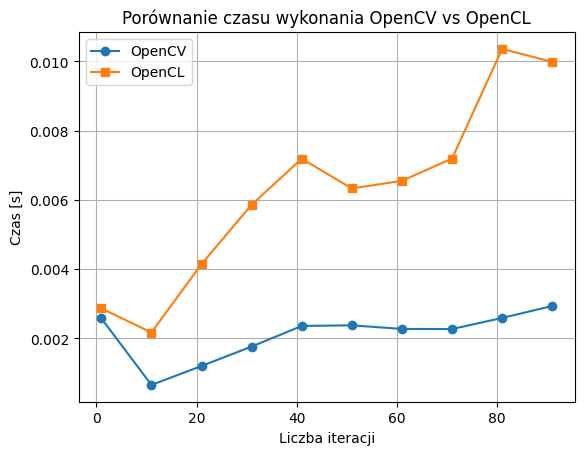

In [1]:
import cv2
import numpy as np
import pyopencl as cl
import time
import matplotlib.pyplot as plt

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return image

# Wczytaj obraz testowy
image = load_image("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab3/SobelFilterImage_Input.bmp")
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# **Test OpenCV - Pomiar czasu dla różnych iteracji**
iterations = list(range(1, 101, 10))
opencv_times = []
opencl_times = []

# **OpenCL Setup**
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

# Konwersja do obrazu RGBA
image_rgba = cv2.cvtColor(image, cv2.COLOR_GRAY2RGBA)
image_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))

kernel_code = """
const int kernel_size = 3;
const int kernel_half = kernel_size / 2;

__constant sampler_t imageSampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP | CLK_FILTER_NEAREST;

__kernel void erode_filter(__read_only image2d_t inputImage, __write_only image2d_t outputImage) 
{
    int2 pose = (int2)(get_global_id(0), get_global_id(1));
    float threshold = 120.0f;
    int max_value = 0.0f;

    for (int dx = -kernel_half; dx <= kernel_half; dx++){
        for (int dy = -kernel_half; dy <= kernel_half; dy++){
            if (dx*dx + dy*dy <= kernel_half*kernel_half){
                int2 dpose = pose + (int2)(dx, dy);
                uint3 pixel = read_imageui(inputImage, imageSampler, dpose).xyz;

                float3 pixel_float = (float3)(pixel.x, pixel.y, pixel.z);

                //printf("%f", pixel_float);
                float gray_pixel = dot(pixel_float, (float3)(0.299f, 0.587f, 0.114f));

                max_value = max(max_value, (int)(255*step(threshold, gray_pixel)*255));
            }     
        }
    }
    write_imagei(outputImage, pose, max_value);
}
"""

# Kompilacja kernela
program = cl.Program(ctx, kernel_code).build()

for num_iter in iterations:
    # **Test OpenCV**
    start_time = time.time()
    for _ in range(num_iter):
        opencv_eroded = cv2.erode(image, kernel, iterations=1)
    opencv_times.append(time.time() - start_time)

    # **Test OpenCL**
    start_time = time.time()
    for _ in range(num_iter):
        program.erode_filter(queue, image.shape, None, image_input, image_output)
        cl.enqueue_barrier(queue)
    opencl_times.append(time.time() - start_time)

# **Wykres czasu wykonania**
plt.plot(iterations, opencv_times, label="OpenCV", marker='o')
plt.plot(iterations, opencl_times, label="OpenCL", marker='s')
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.title("Porównanie czasu wykonania OpenCV vs OpenCL")
plt.legend()
plt.grid()
plt.show()


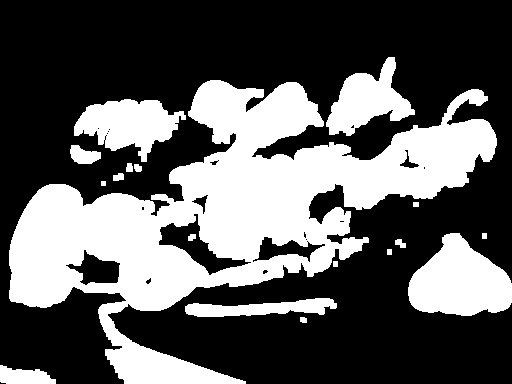

In [9]:
from PIL import Image
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Zakładając, że masz obraz jako numpy array (np. wczytany z pliku lub inny sposób)
# Możesz wczytać obraz przy pomocy PIL i konwertować go na numpy array
image = PIL.Image.fromarray(image)

# 1. Konwertowanie obrazu na odcienie szarości (PIL do NumPy)
image_np = np.array(image.convert('RGB'))  # Konwertuje na RGB, jeśli obraz nie jest w tym formacie
gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)  # Konwertowanie na odcienie szarości

# 2. Zastosowanie progu (threshold)
threshold_value = 100  # Zmienna, którą możesz dostosować
_, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

# 3. Wykonanie erozji
kernel = np.ones((5, 5), np.uint8)  # Można dostosować rozmiar jądra (np. (3, 3), (5, 5))
eroded_image = cv2.dilate(binary_image, kernel, iterations=1)

# 4. Konwertowanie wynikowego obrazu z NumPy z powrotem na obraz PIL i wyświetlenie
eroded_image_pil = Image.fromarray(eroded_image)


eroded_image_pil